<a href="https://www.kaggle.com/code/bharathsingh09/image-captioning?scriptVersionId=273900164" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [37]:
import os

img_dir = '/kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'

# Count images
imgs = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
len(imgs), imgs[:5]


(8091,
 ['3226254560_2f8ac147ea.jpg',
  '214543992_ce6c0d9f9b.jpg',
  '2366643786_9c9a830db8.jpg',
  '3368819708_0bfa0808f8.jpg',
  '2190227737_6e0bde2623.jpg'])

In [38]:
IMG_DIR   = "/kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset"
TEXT_DIR  = "/kaggle/input/flicker8k-dataset/Flickr8k_text"

TOKEN_FILE = f"{TEXT_DIR}/Flickr8k.token.txt"
TRAIN_FILE = f"{TEXT_DIR}/Flickr_8k.trainImages.txt"
DEV_FILE   = f"{TEXT_DIR}/Flickr_8k.devImages.txt"
TEST_FILE  = f"{TEXT_DIR}/Flickr_8k.testImages.txt"


In [2]:
import os

imgs = [f for f in os.listdir(IMG_DIR) if f.endswith(".jpg")]
print(len(imgs))
print(imgs[:5])


8091
['3226254560_2f8ac147ea.jpg', '214543992_ce6c0d9f9b.jpg', '2366643786_9c9a830db8.jpg', '3368819708_0bfa0808f8.jpg', '2190227737_6e0bde2623.jpg']


In [3]:
os.path.exists(TOKEN_FILE)


True

In [4]:
def load_captions(token_file):
    captions = {}
    with open(token_file, 'r') as f:
        for line in f:
            img_cap = line.strip().split("\t")
            filename, caption = img_cap[0].split("#")[0], img_cap[1]
            if filename not in captions:
                captions[filename] = []
            captions[filename].append(caption)
    return captions

captions_dict = load_captions(TOKEN_FILE)
len(captions_dict)


8092

In [5]:
def load_split(file_path):
    with open(file_path, "r") as f:
        return set(line.strip() for line in f)

train_imgs = load_split(TRAIN_FILE)
dev_imgs   = load_split(DEV_FILE)
test_imgs  = load_split(TEST_FILE)

len(train_imgs), len(dev_imgs), len(test_imgs)


(6000, 1000, 1000)

In [6]:
# =========================
# PART 1: DATA & DATALOADERS
# =========================
import os, re, random, math, json
from collections import Counter, defaultdict
from typing import List, Dict, Tuple

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# ---------- Kaggle paths (verified from your run) ----------
IMG_DIR   = "/kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset"
TEXT_DIR  = "/kaggle/input/flicker8k-dataset/Flickr8k_text"

TOKEN_FILE = f"{TEXT_DIR}/Flickr8k.token.txt"
TRAIN_FILE = f"{TEXT_DIR}/Flickr_8k.trainImages.txt"
DEV_FILE   = f"{TEXT_DIR}/Flickr_8k.devImages.txt"
TEST_FILE  = f"{TEXT_DIR}/Flickr_8k.testImages.txt"

# ---------- Small, robust tokenizer (no external downloads) ----------
def basic_tokenize(text: str) -> List[str]:
    # lower, keep basic words/numbers, collapse spaces
    text = text.lower().strip()
    text = re.sub(r"[^a-z0-9' ]+", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.split()

# ---------- Load captions ----------
def load_captions(token_file: str) -> Dict[str, List[str]]:
    caps = defaultdict(list)
    with open(token_file, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            left, cap = line.split("\t")
            fname = left.split("#")[0]
            caps[fname].append(cap)
    return dict(caps)

# ---------- Load image splits ----------
def load_split(path: str) -> List[str]:
    with open(path, "r", encoding="utf-8") as f:
        return [ln.strip() for ln in f if ln.strip()]

all_captions = load_captions(TOKEN_FILE)
train_names  = set(load_split(TRAIN_FILE))
dev_names    = set(load_split(DEV_FILE))
test_names   = set(load_split(TEST_FILE))

# Filter to images that exist on disk
available_images = set(os.listdir(IMG_DIR))
def keep_existing(names: set) -> List[str]:
    return [n for n in names if n in available_images and n in all_captions]

train_names = keep_existing(train_names)
dev_names   = keep_existing(dev_names)
test_names  = keep_existing(test_names)

# ---------- Build vocabulary ----------
PAD, BOS, EOS, UNK = "<pad>", "<bos>", "<eos>", "<unk>"

def build_vocab(captions: Dict[str, List[str]], image_list: List[str], min_freq: int = 5):
    counter = Counter()
    for fname in image_list:
        for cap in captions[fname]:
            counter.update(basic_tokenize(cap))
    # specials first
    itos = [PAD, BOS, EOS, UNK]
    # words by freq (>= min_freq), then alpha to stabilize
    words = [w for w, c in counter.items() if c >= min_freq]
    words.sort()
    itos += words
    stoi = {w:i for i,w in enumerate(itos)}
    return stoi, itos, counter

stoi, itos, word_freq = build_vocab(all_captions, train_names, min_freq=5)
vocab_size = len(itos)

def numericalize(tokens: List[str]) -> List[int]:
    return [stoi.get(t, stoi[UNK]) for t in tokens]

# ---------- Transforms (ImageNet stats for pretrained CNNs) ----------
IMG_SIZE = 224
train_tfms = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
eval_tfms = T.Compose([
    T.Resize(256),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ---------- Dataset ----------
class Flickr8kDataset(Dataset):
    def __init__(self, img_dir: str, names: List[str], captions: Dict[str, List[str]], 
                 vocab_stoi: Dict[str, int], transform, max_len: int = 40, training: bool = True):
        self.img_dir = img_dir
        self.names = list(names)
        self.captions = captions
        self.stoi = vocab_stoi
        self.transform = transform
        self.max_len = max_len
        self.training = training

        # flatten (image, caption) pairs; use all 5 captions during training
        self.pairs = []
        if training:
            for n in self.names:
                for cap in self.captions[n]:
                    self.pairs.append((n, cap))
        else:
            # one caption per image for eval display (we'll still have references elsewhere)
            for n in self.names:
                self.pairs.append((n, self.captions[n][0]))

    def __len__(self):
        return len(self.pairs)

    def _encode_caption(self, cap: str):
        toks = basic_tokenize(cap)
        ids = [self.stoi[BOS]] + numericalize(toks) + [self.stoi[EOS]]
        # truncate / pad
        if len(ids) > self.max_len:
            ids = ids[:self.max_len]
            if ids[-1] != self.stoi[EOS]:
                ids[-1] = self.stoi[EOS]
        return ids

    def __getitem__(self, idx):
        fname, cap = self.pairs[idx]
        path = os.path.join(self.img_dir, fname)
        with Image.open(path).convert("RGB") as img:
            img = self.transform(img)
        cap_ids = self._encode_caption(cap)
        return img, torch.tensor(cap_ids, dtype=torch.long), fname

# ---------- Collate with padding ----------
def pad_sequences(seqs: List[torch.Tensor], pad_value: int) -> torch.Tensor:
    maxlen = max(s.size(0) for s in seqs)
    out = torch.full((len(seqs), maxlen), pad_value, dtype=torch.long)
    for i, s in enumerate(seqs):
        out[i, :s.size(0)] = s
    return out

def collate_batch(batch, pad_idx: int):
    imgs, caps, names = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    caps = pad_sequences(list(caps), pad_idx)
    return imgs, caps, names

# ---------- Instantiate datasets ----------
BATCH_SIZE = 64

train_ds = Flickr8kDataset(IMG_DIR, train_names, all_captions, stoi, train_tfms, training=True)
dev_ds   = Flickr8kDataset(IMG_DIR, dev_names,   all_captions, stoi, eval_tfms, training=False)
test_ds  = Flickr8kDataset(IMG_DIR, test_names,  all_captions, stoi, eval_tfms, training=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=lambda b: collate_batch(b, stoi[PAD]))
dev_loader   = DataLoader(dev_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=lambda b: collate_batch(b, stoi[PAD]))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=lambda b: collate_batch(b, stoi[PAD]))

# ---------- Quick sanity checks ----------
print("Images on disk:", len([f for f in os.listdir(IMG_DIR) if f.endswith(".jpg")]))
print("Train/Val/Test image counts:", len(train_names), len(dev_names), len(test_names))
print("Total (image, caption) train pairs:", len(train_ds))
print("Vocab size:", vocab_size, "| min_freq >= 5")
print("Special tokens:", PAD, BOS, EOS, UNK, "| idx:", stoi[PAD], stoi[BOS], stoi[EOS], stoi[UNK])

# peek a batch
batch_imgs, batch_caps, batch_names = next(iter(train_loader))
print("Batch image tensor:", tuple(batch_imgs.shape))
print("Batch captions tensor:", tuple(batch_caps.shape))
print("Example name:", batch_names[0])
print("Example caption ids (first row):", batch_caps[0, :20].tolist())


Images on disk: 8091
Train/Val/Test image counts: 6000 1000 1000
Total (image, caption) train pairs: 30000
Vocab size: 2539 | min_freq >= 5
Special tokens: <pad> <bos> <eos> <unk> | idx: 0 1 2 3
Batch image tensor: (64, 3, 224, 224)
Batch captions tensor: (64, 30)
Example name: 1355450069_c0675b0706.jpg
Example caption ids (first row): [1, 1295, 2507, 12, 1907, 1115, 453, 12, 1795, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
# =========================
# PART 2: MODEL (Encoder+Attention+Decoder)
# =========================
import math
import torch
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Hyper-params ----------
EMBED_DIM   = 256
ENC_DIM     = 512   # projection dim from CNN features
HIDDEN_DIM  = 512   # LSTM hidden size
ATTN_DIM    = 512
PAD_IDX     = stoi["<pad>"]
BOS_IDX     = stoi["<bos>"]
EOS_IDX     = stoi["<eos>"]

BACKBONE = "resnet50"   # choices: "resnet50", "efficientnet_b0"

# ---------- CNN Encoder (Transfer Learning) ----------
class CNNEncoder(nn.Module):
    def __init__(self, backbone="resnet50", enc_dim=512, train_backbone=False):
        super().__init__()
        self.backbone = backbone

        if backbone == "resnet50":
            weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
            net = torchvision.models.resnet50(weights=weights)
            # keep everything up to the last conv layer (remove avgpool+fc)
            self.cnn = nn.Sequential(*list(net.children())[:-2])  # -> (B, 2048, 7, 7)
            self.out_channels = 2048

        elif backbone == "efficientnet_b0":
            weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
            net = torchvision.models.efficientnet_b0(weights=weights)
            # use feature extractor (no classifier)
            self.cnn = net.features                                 # -> (B, 1280, 7, 7)
            self.out_channels = 1280
        else:
            raise ValueError("Unsupported backbone")

        # Freeze or not
        for p in self.cnn.parameters():
            p.requires_grad = train_backbone

        # 1x1 projection (flatten later, but project channels now)
        self.proj = nn.Sequential(
            nn.Conv2d(self.out_channels, enc_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(enc_dim),
            nn.ReLU(inplace=True),
        )
        self.enc_dim = enc_dim

    def forward(self, images):
        """
        images: (B, 3, 224, 224)
        returns:
            enc_out: (B, K, D) where K = H*W (e.g., 49), D = enc_dim
        """
        with torch.set_grad_enabled(any(p.requires_grad for p in self.cnn.parameters())):
            feats = self.cnn(images)  # (B, C, H, W)
        feats = self.proj(feats)      # (B, D, H, W)
        B, D, H, W = feats.shape
        feats = feats.permute(0, 2, 3, 1).contiguous().view(B, H*W, D)  # (B, K, D)
        return feats  # visual tokens

# ---------- Bahdanau (Additive) Attention ----------
class AdditiveAttention(nn.Module):
    def __init__(self, enc_dim, hid_dim, attn_dim):
        super().__init__()
        self.W_h = nn.Linear(hid_dim, attn_dim, bias=False)
        self.W_f = nn.Linear(enc_dim, attn_dim, bias=False)
        self.v   = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, h_t, enc_out, mask=None):
        """
        h_t:     (B, H)      current decoder hidden
        enc_out: (B, K, D)   encoder visual tokens
        mask:    (B, K)      optional mask (not needed here)
        returns:
            context: (B, D)
            attn:    (B, K)
        """
        B, K, D = enc_out.shape
        # expand decoder state across K
        h = self.W_h(h_t).unsqueeze(1).expand(B, K, -1)        # (B, K, A)
        f = self.W_f(enc_out)                                  # (B, K, A)
        e = self.v(torch.tanh(h + f)).squeeze(-1)              # (B, K)
        if mask is not None:
            e = e.masked_fill(~mask, -1e9)
        alpha = torch.softmax(e, dim=1)                        # (B, K)
        context = torch.bmm(alpha.unsqueeze(1), enc_out).squeeze(1)  # (B, D)
        return context, alpha

# ---------- Decoder with Attention + LSTM ----------
class AttnLSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_dim, hidden_dim, attn_dim, pad_idx=0, tie_weights=True, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.attn  = AdditiveAttention(enc_dim, hidden_dim, attn_dim)
        # input to LSTM is [emb_t ; context]
        self.lstm  = nn.LSTM(input_size=embed_dim + enc_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.drop  = nn.Dropout(dropout)
        self.fc    = nn.Linear(hidden_dim, vocab_size)
        if tie_weights:
            # project hidden to embedding space before tying
            self.htoe = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.fc = nn.Linear(embed_dim, vocab_size, bias=False)
            self.fc.weight = self.embed.weight  # weight tying

        self.pad_idx = pad_idx
        self.use_tied = tie_weights

    def forward(self, enc_out, captions):
        """
        Teacher-forced training forward.
        enc_out: (B, K, D)
        captions: (B, T) with BOS ... EOS ... PAD
        returns:
            logits: (B, T-1, V) predicting next token for each step t
        """
        B, K, D = enc_out.shape
        # inputs exclude last token; targets exclude first token
        inp = captions[:, :-1]   # (B, T-1)
        tgt = captions[:, 1:]    # (B, T-1)

        emb = self.embed(inp)    # (B, T-1, E)

        # init hidden/cell with zeros
        h, c = (torch.zeros(1, B, HIDDEN_DIM, device=enc_out.device),
                torch.zeros(1, B, HIDDEN_DIM, device=enc_out.device))

        outputs = []
        for t in range(emb.size(1)):
            emb_t = emb[:, t, :]                         # (B, E)
            h_t = h[-1]                                  # (B, H)
            context, alpha = self.attn(h_t, enc_out)     # (B, D)
            lstm_in = torch.cat([emb_t, context], dim=1).unsqueeze(1)  # (B,1,E+D)
            out, (h, c) = self.lstm(lstm_in, (h, c))     # out: (B,1,H)
            out = out.squeeze(1)                         # (B,H)
            out = self.drop(out)
            if self.use_tied:
                out = self.htoe(out)                     # (B,E)
            logits = self.fc(out)                        # (B,V)
            outputs.append(logits)

        logits = torch.stack(outputs, dim=1)             # (B, T-1, V)
        return logits, tgt

# ---------- Wrapper Model ----------
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, backbone="resnet50"):
        super().__init__()
        self.encoder = CNNEncoder(backbone=backbone, enc_dim=ENC_DIM, train_backbone=False)
        self.decoder = AttnLSTMDecoder(
            vocab_size=vocab_size,
            embed_dim=EMBED_DIM,
            enc_dim=ENC_DIM,
            hidden_dim=HIDDEN_DIM,
            attn_dim=ATTN_DIM,
            pad_idx=PAD_IDX,
            tie_weights=True,
            dropout=0.1,
        )

    def forward(self, images, captions):
        enc_out = self.encoder(images)               # (B, K, D)
        logits, tgt = self.decoder(enc_out, captions)
        return logits, tgt

# ---------- Instantiate & Sanity Pass ----------
model = ImageCaptioningModel(vocab_size=vocab_size, backbone=BACKBONE).to(device)
print(model.encoder)

# Loss with padding ignored
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Do one batch through the model (no grad) to verify shapes
model.eval()
with torch.no_grad():
    imgs_b, caps_b, names_b = next(iter(train_loader))
    imgs_b, caps_b = imgs_b.to(device), caps_b.to(device)
    logits, tgt = model(imgs_b, caps_b)  # logits: (B, T-1, V), tgt: (B, T-1)
    loss = criterion(logits.reshape(-1, logits.size(-1)), tgt.reshape(-1))

print("Encoder output shape:", model.encoder(torch.zeros_like(imgs_b[:2]).to(device)).shape)  # (2, K, D)
print("Logits shape:", tuple(logits.shape))
print("Targets shape:", tuple(tgt.shape))
print("Sample loss:", float(loss.item()))


Device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


CNNEncoder(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [8]:
# =========================
# PART 3: TRAINING PIPELINE
# =========================

import time
import torch
from torch import nn, optim

NUM_EPOCHS   = 3        # increase later
LR           = 1e-3
CLIP_GRAD_NN = 5.0

save_path = "best_model.pt"

optimizer = optim.Adam(model.parameters(), lr=LR)


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    t0 = time.time()

    for imgs, caps, _ in loader:
        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()
        logits, tgt = model(imgs, caps)               # (B,T-1,V),(B,T-1)
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt.reshape(-1)
        )
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NN)
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, time.time() - t0


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    for imgs, caps, _ in loader:
        imgs = imgs.to(device)
        caps = caps.to(device)
        logits, tgt = model(imgs, caps)
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt.reshape(-1)
        )
        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)


# ---------- Greedy Caption Generation ----------
def greedy_decode(model, image, max_length=30):
    """
    image: (3,224,224) tensor already normalized
    returns token list
    """
    model.eval()
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        enc_out = model.encoder(image)     # (1,K,D)

        # init states
        h = torch.zeros(1, 1, HIDDEN_DIM, device=device)
        c = torch.zeros(1, 1, HIDDEN_DIM, device=device)

        # BOS
        cur = torch.tensor([BOS_IDX], device=device).unsqueeze(0)  # (1,1)

        caption = []
        for _ in range(max_length):
            emb = model.decoder.embed(cur).squeeze(1)   # (1,E)

            h_t = h[-1]                                 # (1,H)
            context, _ = model.decoder.attn(h_t, enc_out)

            lstm_in = torch.cat([emb, context], dim=1).unsqueeze(1) # (1,1,E+D)
            out, (h, c) = model.decoder.lstm(lstm_in, (h, c))
            out = out.squeeze(1)

            if model.decoder.use_tied:
                out = model.decoder.htoe(out)

            logits = model.decoder.fc(out)              # (1,V)
            nxt = logits.argmax(-1).item()

            if nxt == EOS_IDX:
                break
            caption.append(itos[nxt])
            cur = torch.tensor([[nxt]], device=device)

        return caption


# =============== TRAINING ===============
best_val = float("inf")

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_time = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss = evaluate(model, dev_loader, criterion, device)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Time: {train_time:.1f}s")

    # Save if best
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), save_path)
        print("  ✅ Saved new best model")

# =============== QUICK TEST ===============
print("\nGreedy test generation:")
imgs, caps, names = next(iter(test_loader))
pred = greedy_decode(model, imgs[0])
print("Image name:", names[0])
print("Pred:", " ".join(pred))


Epoch 01 | Train Loss: 3.7707 | Val Loss: 3.1821 | Time: 178.4s
  ✅ Saved new best model
Epoch 02 | Train Loss: 3.0348 | Val Loss: 2.9740 | Time: 163.2s
  ✅ Saved new best model
Epoch 03 | Train Loss: 2.7523 | Val Loss: 2.9266 | Time: 162.5s
  ✅ Saved new best model

Greedy test generation:
Image name: 3285993030_87b0f1d202.jpg
Pred: a black and white dog is running through the water



Greedy test generation:


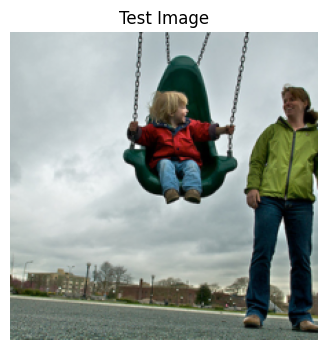


📌 Image name: 3399284917_721aefe2a7.jpg

✅ Ground-truth captions:
 • A child on a kiddie swing being pushed by a woman
 • An adult smiles with a child on a swing .
 • A young woman watches as a young blond boy swings in a chair swing with buildings visible in the background .
 • The woman stands outdoors , next to a child in a swing .
 • Woman standing , with a child on a swing .

🤖 Predicted:
  a man in a blue shirt is swinging on a swing


In [9]:
# =============== QUICK TEST (with original captions + image) ===============
import matplotlib.pyplot as plt
import numpy as np

def show_image(img_tensor):
    """
    Undo image normalization & show
    """
    img = img_tensor.cpu().permute(1,2,0).numpy()
    # undo imagenet normalization
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")


print("\nGreedy test generation:")
imgs, caps, names = next(iter(test_loader))
name = names[1]
img  = imgs[1]

pred = greedy_decode(model, img)

# Show
plt.figure(figsize=(4,4))
show_image(img)
plt.title("Test Image")
plt.show()

print("\n📌 Image name:", name)

# original Flicker8k captions
print("\n✅ Ground-truth captions:")
for c in all_captions[name]:
    print(" •", c)

print("\n🤖 Predicted:")
print(" ", " ".join(pred))


In [10]:
# =========================
# PART 4: Fine-tune CNN
# =========================

# Unfreeze last stage of ResNet50
def unfreeze_last_resnet_blocks(model):
    for name, param in model.encoder.cnn.named_parameters():
        # For ResNet50 last block is layer4
        if "layer4" in name:
            param.requires_grad = True

    # keep projection trainable
    for p in model.encoder.proj.parameters():
        p.requires_grad = True

    print("✅ Unfroze layer4 of ResNet + projection layer.")

unfreeze_last_resnet_blocks(model)

# New (smaller) LR
FT_LR = 1e-5
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=FT_LR
)

NUM_EPOCHS_FT = 2   # increase as needed

best_val_ft = best_val

for epoch in range(1, NUM_EPOCHS_FT + 1):

    train_loss, train_time = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss = evaluate(model, dev_loader, criterion, device)

    print(f"[FT] Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Time: {train_time:.1f}s")

    if val_loss < best_val_ft:
        best_val_ft = val_loss
        torch.save(model.state_dict(), "best_model_ft.pt")
        print("  ✅ Saved improved fine-tuned model")


✅ Unfroze layer4 of ResNet + projection layer.
[FT] Epoch 01 | Train Loss: 2.4173 | Val Loss: 2.8682 | Time: 164.2s
  ✅ Saved improved fine-tuned model
[FT] Epoch 02 | Train Loss: 2.3628 | Val Loss: 2.8606 | Time: 167.3s
  ✅ Saved improved fine-tuned model


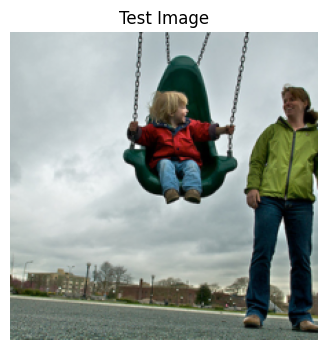


📌 Image: 3399284917_721aefe2a7.jpg

✅ Ground-truth:
 • A child on a kiddie swing being pushed by a woman
 • An adult smiles with a child on a swing .
 • A young woman watches as a young blond boy swings in a chair swing with buildings visible in the background .
 • The woman stands outdoors , next to a child in a swing .
 • Woman standing , with a child on a swing .

🤖 Predicted after fine-tuning:
  a boy swings high in the air


In [11]:
imgs, caps, names = next(iter(test_loader))
name = names[1]
img  = imgs[1]

pred = greedy_decode(model, img)

plt.figure(figsize=(4,4))
show_image(img)
plt.title("Test Image")
plt.show()

print("\n📌 Image:", name)

print("\n✅ Ground-truth:")
for c in all_captions[name]:
    print(" •", c)

print("\n🤖 Predicted after fine-tuning:")
print(" ", " ".join(pred))


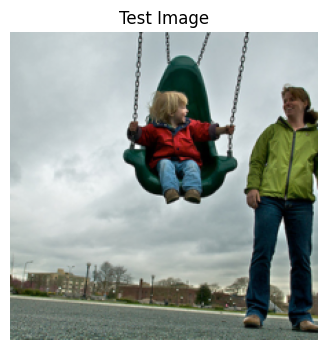


📌 Image: 3399284917_721aefe2a7.jpg

✅ Ground-truth:
 • A child on a kiddie swing being pushed by a woman
 • An adult smiles with a child on a swing .
 • A young woman watches as a young blond boy swings in a chair swing with buildings visible in the background .
 • The woman stands outdoors , next to a child in a swing .
 • Woman standing , with a child on a swing .

🤖 Greedy:
  a boy swings high in the air

🤖 Beam search:
  a boy swings high in the air


In [12]:
# =========================
# PART 5: BEAM SEARCH
# =========================

@torch.no_grad()
def beam_search_decode(model, image, beam_size=3, max_len=30):
    """
    image: (3,224,224)
    returns: best caption as list of tokens
    """
    model.eval()
    image = image.unsqueeze(0).to(device)
    enc_out = model.encoder(image)     # (1,K,D)

    # (hidden, cell)
    h = torch.zeros(1, 1, HIDDEN_DIM, device=device)
    c = torch.zeros(1, 1, HIDDEN_DIM, device=device)

    # each beam entry => (tokens, h, c, score)
    beams = [( [BOS_IDX], h, c, 0.0 )]

    for _ in range(max_len):
        new_beams = []
        for tokens, h, c, score in beams:
            if tokens[-1] == EOS_IDX:
                new_beams.append((tokens, h, c, score))
                continue

            cur = torch.tensor([[tokens[-1]]], device=device) # (1,1)
            emb = model.decoder.embed(cur).squeeze(1)         # (1,E)
            h_t = h[-1]                                       # (1,H)
            context, _ = model.decoder.attn(h_t, enc_out)

            lstm_in = torch.cat([emb, context], dim=1).unsqueeze(1) # (1,1,E+D)
            out, (new_h, new_c) = model.decoder.lstm(lstm_in, (h, c))
            out = out.squeeze(1)

            if model.decoder.use_tied:
                out = model.decoder.htoe(out)

            logits = model.decoder.fc(out).squeeze(0)         # (V,)
            logprobs = torch.log_softmax(logits, dim=-1)

            # top candidates
            vals, idxs = torch.topk(logprobs, beam_size)
            for v, ix in zip(vals, idxs):
                new_beams.append((
                    tokens + [ix.item()], 
                    new_h, new_c, 
                    score + v.item()
                ))

        # keep best beams
        new_beams = sorted(new_beams, key=lambda x: x[3], reverse=True)
        beams = new_beams[:beam_size]

        # stop if all beams ended
        if all(t[-1] == EOS_IDX for t,_,_,_ in beams):
            break

    best = beams[0][0]
    caption = []
    for idx in best[1:]:
        if idx == EOS_IDX:
            break
        caption.append(itos[idx])
    return caption
imgs, caps, names = next(iter(test_loader))
name = names[1]
img  = imgs[1]

beam_pred = beam_search_decode(model, img, beam_size=3)
greedy_pred = greedy_decode(model, img)

plt.figure(figsize=(4,4))
show_image(img)
plt.title("Test Image")
plt.show()

print("\n📌 Image:", name)

print("\n✅ Ground-truth:")
for c in all_captions[name]:
    print(" •", c)

print("\n🤖 Greedy:")
print(" ", " ".join(greedy_pred))

print("\n🤖 Beam search:")
print(" ", " ".join(beam_pred))


In [13]:
# If not already installed
!pip install nltk


In [14]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth = SmoothingFunction().method1


In [15]:
# =========================
# PART 6: BLEU Evaluation
# =========================

def evaluate_bleu(model, loader, all_captions, beam_size=3, max_samples=300):
    """
    Evaluate BLEU on a subset of test dataset (default 300 images)
    """
    bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores = [], [], [], []
    count = 0

    model.eval()

    for imgs, _, names in loader:
        for i in range(len(names)):
            fname = names[i]
            gt_caps = all_captions[fname]  # list of strings
            refs = [basic_tokenize(c) for c in gt_caps]

            # image raw
            img = imgs[i]

            # predicted caption (beam)
            hyp = beam_search_decode(model, img, beam_size=beam_size)

            # BLEU scores
            bleu1 = sentence_bleu(refs, hyp, weights=(1,0,0,0), smoothing_function=smooth)
            bleu2 = sentence_bleu(refs, hyp, weights=(0.5,0.5,0,0), smoothing_function=smooth)
            bleu3 = sentence_bleu(refs, hyp, weights=(0.33,0.33,0.33,0), smoothing_function=smooth)
            bleu4 = sentence_bleu(refs, hyp, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth)

            bleu1_scores.append(bleu1)
            bleu2_scores.append(bleu2)
            bleu3_scores.append(bleu3)
            bleu4_scores.append(bleu4)

            count += 1
            if count >= max_samples:
                break
        if count >= max_samples:
            break

    return {
        "BLEU-1": sum(bleu1_scores)/len(bleu1_scores),
        "BLEU-2": sum(bleu2_scores)/len(bleu2_scores),
        "BLEU-3": sum(bleu3_scores)/len(bleu3_scores),
        "BLEU-4": sum(bleu4_scores)/len(bleu4_scores),
    }

# Run BLEU evaluation
bleu_scores = evaluate_bleu(model, test_loader, all_captions, beam_size=3, max_samples=300)
bleu_scores


{'BLEU-1': 0.5767888108037196,
 'BLEU-2': 0.3809346814100457,
 'BLEU-3': 0.24432619198207112,
 'BLEU-4': 0.16344891723931065}

In [16]:
SAVE_PATH = "caption_model.pt"
torch.save(model.state_dict(), SAVE_PATH)
print("✅ Model saved to:", SAVE_PATH)


✅ Model saved to: caption_model.pt


In [17]:
# =========================
# LOAD MODEL
# =========================

loaded_model = ImageCaptioningModel(
    vocab_size=vocab_size,
    backbone=BACKBONE        # "resnet50" or "efficientnet_b0"
).to(device)

state = torch.load(SAVE_PATH, map_location=device)
loaded_model.load_state_dict(state)
loaded_model.eval()

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [18]:
from PIL import Image
import torchvision.transforms as T

def load_and_preprocess(image_path):
    img = Image.open(image_path).convert("RGB")
    return eval_tfms(img)   # already defined in Part-1


In [19]:
# =========================
# GENERATE CAPTION FROM FILE
# =========================

def caption_image_from_path(model, image_path, method="beam", beam_size=3):
    img_t = load_and_preprocess(image_path)
    
    if method == "beam":
        tokens = beam_search_decode(model, img_t, beam_size=beam_size)
    else:
        tokens = greedy_decode(model, img_t)

    return " ".join(tokens)



🤖 Caption:
 a man in a yellow shirt is skateboarding down a handrail


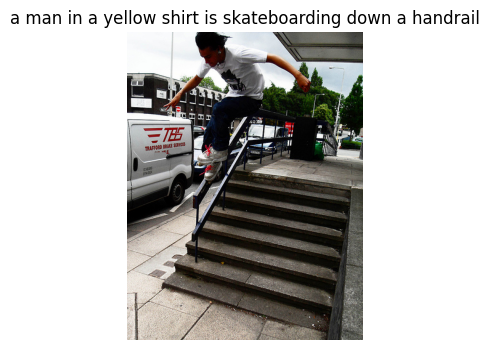

In [20]:
test_img = "/kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/3702436188_2c26192fd0.jpg"

caption = caption_image_from_path(loaded_model, test_img, method="beam", beam_size=3)
print("\n🤖 Caption:\n", caption)
import matplotlib.pyplot as plt
import numpy as np

def display_caption(image_path, caption):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption)
    plt.show()


cap = caption_image_from_path(loaded_model, test_img, "beam", beam_size=3)
display_caption(test_img, cap)




🤖 Caption:
 a brown and white dog is running on the beach


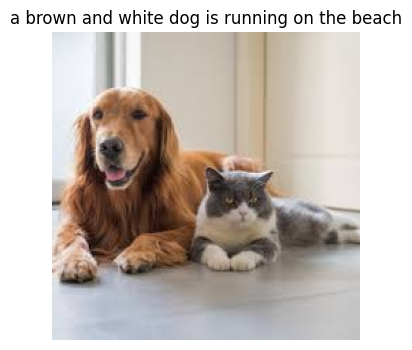

In [21]:
test_img = "/kaggle/input/unknown/Dog_Cat.jpg"

caption = caption_image_from_path(loaded_model, test_img, method="beam", beam_size=3)
print("\n🤖 Caption:\n", caption)
import matplotlib.pyplot as plt
import numpy as np

def display_caption(image_path, caption):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption)
    plt.show()


cap = caption_image_from_path(loaded_model, test_img, "beam", beam_size=3)
display_caption(test_img, cap)




🤖 Caption:
 a man in a red shirt is running on the grass


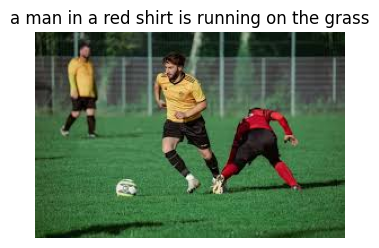

In [22]:
test_img = "/kaggle/input/unknown/Yellow_red_football.jpg"

caption = caption_image_from_path(loaded_model, test_img, method="beam", beam_size=3)
print("\n🤖 Caption:\n", caption)
import matplotlib.pyplot as plt
import numpy as np

def display_caption(image_path, caption):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption)
    plt.show()


cap = caption_image_from_path(loaded_model, test_img, "beam", beam_size=3)
display_caption(test_img, cap)




🤖 Caption:
 a white dog with a yellow toy in its mouth


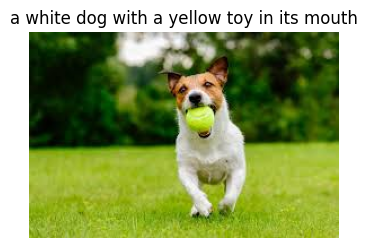

In [23]:
test_img = "/kaggle/input/unknown/download.jpg"

caption = caption_image_from_path(loaded_model, test_img, method="beam", beam_size=3)
print("\n🤖 Caption:\n", caption)
import matplotlib.pyplot as plt
import numpy as np

def display_caption(image_path, caption):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption)
    plt.show()


cap = caption_image_from_path(loaded_model, test_img, "beam", beam_size=3)
display_caption(test_img, cap)




🤖 Caption:
 a soccer player in a red uniform is about to kick a soccer ball


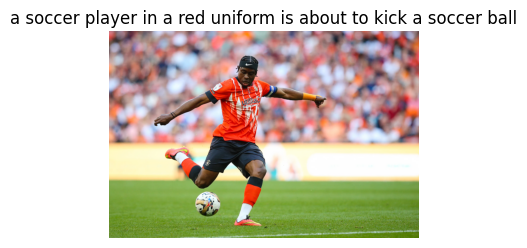

In [24]:
test_img = "/kaggle/input/unknown/red_football.webp"

caption = caption_image_from_path(loaded_model, test_img, method="beam", beam_size=3)
print("\n🤖 Caption:\n", caption)
import matplotlib.pyplot as plt
import numpy as np

def display_caption(image_path, caption):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption)
    plt.show()


cap = caption_image_from_path(loaded_model, test_img, "beam", beam_size=3)
display_caption(test_img, cap)



In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/unknown'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unknown/Yellow_red_football.jpg
/kaggle/input/unknown/red_football.webp
/kaggle/input/unknown/Dog_Cat.jpg
/kaggle/input/unknown/download.jpg



🤖 Caption:
 a man in a red shirt is running on the grass


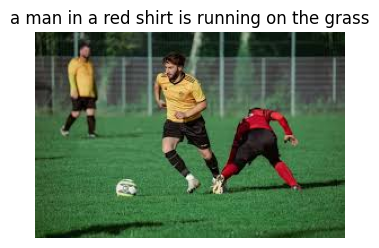


🤖 Caption:
 a soccer player in a red uniform is about to kick a soccer ball


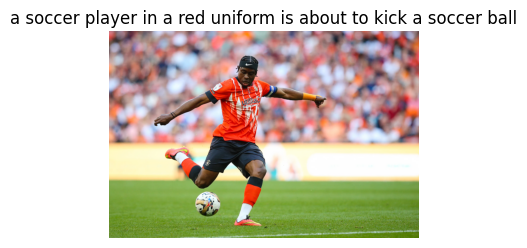


🤖 Caption:
 a brown and white dog is running on the beach


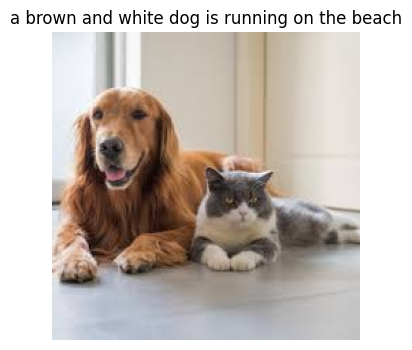


🤖 Caption:
 a white dog with a yellow toy in its mouth


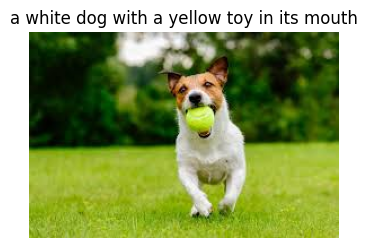

In [26]:
for dirname, _, filenames in os.walk('/kaggle/input/unknown'):
    for filename in filenames:
        test_img=os.path.join(dirname, filename)


    
        #test_img = "/kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/3702436188_2c26192fd0.jpg"
        
        caption = caption_image_from_path(loaded_model, test_img, method="beam", beam_size=3)
        print("\n🤖 Caption:\n", caption)
        import matplotlib.pyplot as plt
        import numpy as np
        
        def display_caption(image_path, caption):
            img = Image.open(image_path).convert("RGB")
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.axis("off")
            plt.title(caption)
            plt.show()
        
        
        cap = caption_image_from_path(loaded_model, test_img, "beam", beam_size=3)
        display_caption(test_img, cap)



In [27]:
!git clone https://github.com/tylin/coco-caption.git
!pip install pycocoevalcap


Cloning into 'coco-caption'...
remote: Enumerating objects: 736, done.
remote: Total 736 (delta 0), reused 0 (delta 0), pack-reused 736 (from 1)
Receiving objects: 100% (736/736), 130.04 MiB | 32.12 MiB/s, done.
Resolving deltas: 100% (390/390), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.7 MB/s eta 0:00:0000:0100:01


In [28]:
# ====== CIDEr Evaluation ======
from pycocoevalcap.cider.cider import Cider

def compute_cider_score(references, hypotheses):
    """
    references: dict {image_id: [list of GT captions]}
    hypotheses: dict {image_id: [predicted caption]}
    """
    cider = Cider()
    score, _ = cider.compute_score(references, hypotheses)
    return score


In [29]:
# Build dictionaries

# references: { image_id: [gt1, gt2, gt3, gt4, gt5] }
# predictions: { image_id: [pred_caption] }

references = {}
predictions = {}

for imgs, _, names in test_loader:
    for i in range(len(names)):
        name = names[i]
        img = imgs[i]

        # Ground-truth text
        refs = all_captions[name]           # list of strings
        references[name] = refs

        # Prediction (beam)
        pred = " ".join(beam_search_decode(model, img))
        predictions[name] = [pred]

# Only evaluate subset if slow
# references = dict(list(references.items())[:300])
# predictions = dict(list(predictions.items())[:300])

cider_score = compute_cider_score(references, predictions)
print("CIDEr Score:", cider_score)


CIDEr Score: 0.4101592327103097


In [30]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-t0uv0tx9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-t0uv0tx9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB

In [31]:
# ========= CLIPScore ==========
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)


@torch.no_grad()
def clip_score(image, caption):
    """
    image : PIL Image
    caption : string
    """
    image_input = preprocess_clip(image).unsqueeze(0).to(device)
    text_input  = clip.tokenize([caption]).to(device)

    image_features = model_clip.encode_image(image_input)
    text_features  = model_clip.encode_text(text_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)

    similarity = (image_features @ text_features.T).item()   # cosine
    return similarity



100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 186MiB/s]


In [34]:
# ----------- Helper: Convert normalized tensor → PIL Image -----------

import numpy as np
from PIL import Image

def to_PIL(t):
    """
    Convert image tensor (3x224x224) normalized to ImageNet stats
    back to a displayable PIL image
    """
    img = t.permute(1,2,0).cpu().numpy()          # CHW → HWC
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img * std + mean                        # de-normalize
    img = np.clip(img, 0, 1)
    img = (img * 255).astype("uint8")
    return Image.fromarray(img)


In [36]:
def evaluate_clip(model, loader, n_samples=300):
    scores = []

    for imgs, _, names in loader:
        for i in range(len(names)):
            img_tensor = imgs[i]
            pil_img = to_PIL(img_tensor)

            pred = " ".join(beam_search_decode(model, img_tensor))
            sc = clip_score(pil_img, pred)
            scores.append(sc)

            if len(scores) >= n_samples:
                return sum(scores)/len(scores)

    return sum(scores)/len(scores)


clip_avg = evaluate_clip(model, test_loader, n_samples=200)
print("Average CLIPScore:", clip_avg)




Average CLIPScore: 0.2662158203125
